<a href="https://colab.research.google.com/github/tcapelle/python_ines/blob/master/Deep_Learning_in_GPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
 !curl https://raw.githubusercontent.com/tcapelle/python_ines/master/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   383  100   383    0     0   1160      0 --:--:-- --:--:-- --:--:--  1160
    100% |████████████████████████████████| 153kB 6.8MB/s 
    100% |████████████████████████████████| 61kB 26.1MB/s 
    100% |████████████████████████████████| 591.8MB 25kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x6103a000 @  0x7fdf626ee2a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
    100% |████████████████████████████████| 112kB 30.6MB/s 
  Running setup.py bdist_wheel for nvidia-ml-py3 ... - done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup

In [0]:
!pip install --upgrade pillow

  Using cached https://files.pythonhosted.org/packages/92/e3/217dfd0834a51418c602c96b110059c477260c7fee898542b100913947cf/Pillow-5.4.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.1.1
    Uninstalling Pillow-4.1.1:
      Successfully uninstalled Pillow-4.1.1


# DL model in GPU

In [0]:
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

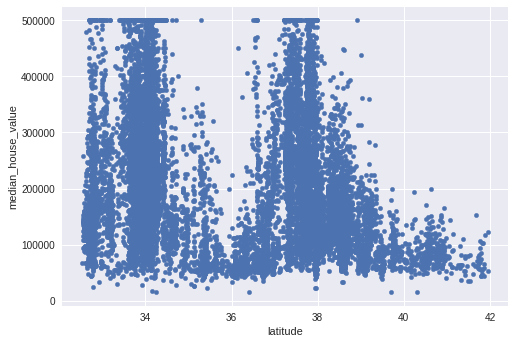

In [4]:
california_housing_dataframe.plot.scatter(x='latitude', y='median_house_value')

In [0]:
dep_var = 'median_house_value'
cat_names = []
cont_names = ['latitude','longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']


In [0]:
procs = [FillMissing, Normalize]

In [7]:
#random split of train/valid dataframe
np.random.seed(9001)
idx = np.random.permutation(range(17000))[:2000]
idx.sort()
idx

array([    1,     5,    13,    18, ..., 16964, 16972, 16980, 16981])

In [0]:
data = (TabularList.from_df(california_housing_dataframe, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                           .databunch())

In [0]:
max_log_y = np.log(np.max(california_housing_dataframe[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], emb_szs={}, 
                        y_range=y_range, metrics=exp_rmspe)

In [11]:
learn.model

TabularModel(
  (embeds): ModuleList()
  (emb_drop): Dropout(p=0.0)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=8, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=1000, out_features=500, bias=True)
    (4): ReLU(inplace)
    (5): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [12]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,17.975451,10.698076,0.951343
2,0.456851,0.253782,0.401620
3,0.150509,0.143967,0.416078
4,0.121176,0.103326,0.361429
5,0.107310,0.093275,0.350617
6,0.096524,0.085896,0.303081
7,0.087710,0.088562,0.325481
8,0.081871,0.118204,0.288817
9,0.077631,0.081407,0.282722
10,0.076612,0.104020,0.278376


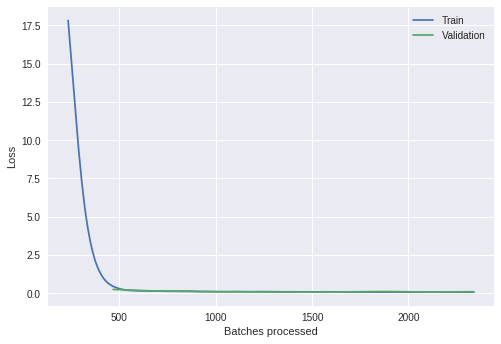

In [13]:
learn.recorder.plot_losses(last=-1)

# MNIST CNN

In [0]:
%matplotlib inline
from fastai import *
from fastai.vision import *

In [0]:
path = untar_data(URLs.MNIST)

In [16]:
path.ls()

[PosixPath('/root/.fastai/data/mnist_png/testing'),
 PosixPath('/root/.fastai/data/mnist_png/training')]

In [0]:
il = ImageItemList.from_folder(path, convert_mode='L')

In [18]:
il.items[0]

PosixPath('/root/.fastai/data/mnist_png/testing/7/9608.png')

In [0]:
defaults.cmap='binary'

In [20]:
il

ImageItemList (70000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png

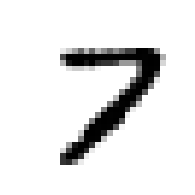

In [21]:
il[0].show()

In [0]:
sd = il.split_by_folder(train='training', valid='testing')

In [23]:
sd

ItemLists;

Train: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [24]:
(path/'training').ls()

[PosixPath('/root/.fastai/data/mnist_png/training/7'),
 PosixPath('/root/.fastai/data/mnist_png/training/9'),
 PosixPath('/root/.fastai/data/mnist_png/training/0'),
 PosixPath('/root/.fastai/data/mnist_png/training/4'),
 PosixPath('/root/.fastai/data/mnist_png/training/6'),
 PosixPath('/root/.fastai/data/mnist_png/training/5'),
 PosixPath('/root/.fastai/data/mnist_png/training/1'),
 PosixPath('/root/.fastai/data/mnist_png/training/2'),
 PosixPath('/root/.fastai/data/mnist_png/training/8'),
 PosixPath('/root/.fastai/data/mnist_png/training/3')]

In [0]:
ll = sd.label_from_folder()

In [26]:
ll

LabelLists;

Train: LabelList
y: CategoryList (60000 items)
[Category 7, Category 7, Category 7, Category 7, Category 7]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (60000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Valid: LabelList
y: CategoryList (10000 items)
[Category 7, Category 7, Category 7, Category 7, Category 7]...
Path: /root/.fastai/data/mnist_png
x: ImageItemList (10000 items)
[Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28), Image (1, 28, 28)]...
Path: /root/.fastai/data/mnist_png;

Test: None

In [0]:
x,y = ll.train[0]

7 torch.Size([1, 28, 28])


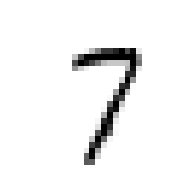

In [28]:
x.show()
print(y,x.shape)

In [0]:
tfms = ([*rand_pad(padding=3, size=28, mode='zeros')], [])

In [0]:
ll = ll.transform(tfms)

In [0]:
bs = 128

In [0]:
data = ll.databunch(bs=bs).normalize()

In [0]:
x,y = data.train_ds[0]

7


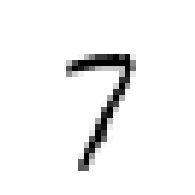

In [34]:
x.show()
print(y)

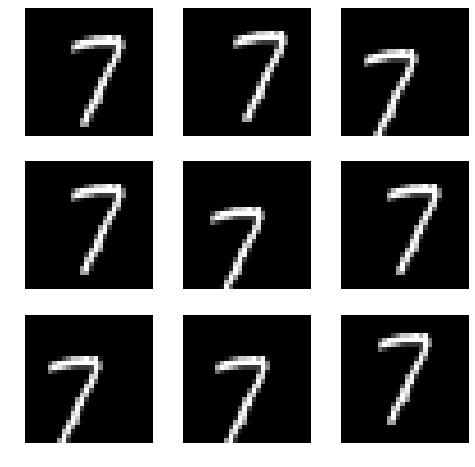

In [35]:
def _plot(i,j,ax): data.train_ds[0][0].show(ax, cmap='gray')
plot_multi(_plot, 3, 3, figsize=(8,8))

In [36]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

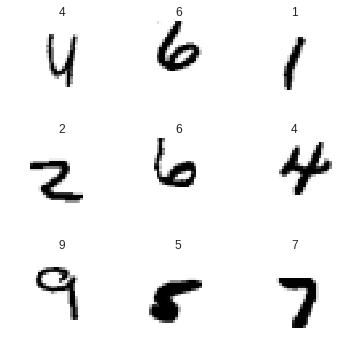

In [37]:
data.show_batch(rows=3, figsize=(5,5))

## Basic CNN

In [0]:
def conv(ni,nf): return nn.Conv2d(ni, nf, kernel_size=3, stride=2, padding=1)

In [0]:
model = nn.Sequential(
    conv(1, 8), # 14
    nn.BatchNorm2d(8),
    nn.ReLU(),
    conv(8, 16), # 7
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 32), # 4
    nn.BatchNorm2d(32),
    nn.ReLU(),
    conv(32, 16), # 2
    nn.BatchNorm2d(16),
    nn.ReLU(),
    conv(16, 10), # 1
    nn.BatchNorm2d(10),
    Flatten()     # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [43]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     80         True      
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
Conv2d               [128, 16, 7, 7]      1168       True      
______________________________________________________________________
BatchNorm2d          [128, 16, 7, 7]      32         True      
______________________________________________________________________
ReLU                 [128, 16, 7, 7]      0          False     
______________________________________________________________________
Conv2d               [128, 32, 4, 4]      4640       True      
______________________________________________________________

In [0]:
xb = xb.cuda()

In [45]:
model(xb).shape

torch.Size([128, 10])

In [46]:
learn.lr_find(end_lr=100)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


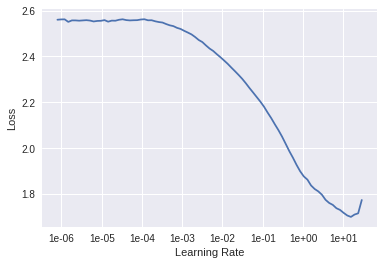

In [47]:
learn.recorder.plot()

In [48]:
learn.fit_one_cycle(3, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.217689,0.154193,0.950800
2,0.141532,0.112126,0.963000
3,0.068445,0.039063,0.988200


## Refactor

In [0]:
def conv2(ni,nf): return conv_layer(ni,nf,stride=2)

In [0]:
model = nn.Sequential(
    conv2(1, 8),   # 14
    conv2(8, 16),  # 7
    conv2(16, 32), # 4
    conv2(32, 16), # 2
    conv2(16, 10), # 1
    Flatten()      # remove (1,1) grid
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [0]:
learn.fit_one_cycle(10, max_lr=0.1)

epoch,train_loss,valid_loss,accuracy
1,0.249092,0.145831,0.957600
2,0.196520,0.231148,0.926200
3,0.162156,0.121741,0.963100
4,0.137518,0.123255,0.958700
5,0.114836,0.191004,0.941800
6,0.105626,0.075536,0.975900
7,0.087983,0.045720,0.985500
8,0.068826,0.046301,0.986000
9,0.051475,0.030821,0.991100
10,0.050744,0.029381,0.991600


## Resnet-ish

In [0]:
class ResBlock(nn.Module):
    def __init__(self, nf):
        super().__init__()
        self.conv1 = conv_layer(nf,nf)
        self.conv2 = conv_layer(nf,nf)
        
    def forward(self, x): return x + self.conv2(self.conv1(x))

In [0]:
model = nn.Sequential(
    conv2(1, 8),
    res_block(8),
    conv2(8, 16),
    res_block(16),
    conv2(16, 32),
    res_block(32),
    conv2(32, 16),
    res_block(16),
    conv2(16, 10),
    Flatten()
)

In [0]:
def conv_and_res(ni,nf): return nn.Sequential(conv2(ni, nf), res_block(nf))

In [0]:
model = nn.Sequential(
    conv_and_res(1, 8),
    conv_and_res(8, 16),
    conv_and_res(16, 32),
    conv_and_res(32, 16),
    conv2(16, 10),
    Flatten()
)

In [0]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

epoch,train_loss,valid_loss,accuracy


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


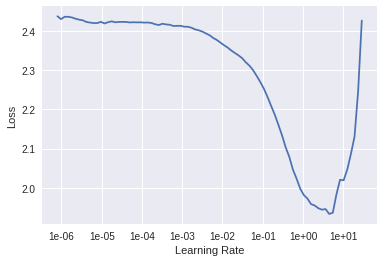

In [0]:
learn.lr_find(end_lr=100)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(12, max_lr=0.05)

epoch,train_loss,valid_loss,accuracy
1,0.229725,0.190041,0.945800
2,0.130763,0.073761,0.976300
3,0.098851,0.110575,0.966700
4,0.085101,0.145754,0.951700
5,0.073958,0.061462,0.981800
6,0.061645,0.045064,0.985100
7,0.050730,0.041523,0.987200
8,0.038168,0.024006,0.992200
9,0.032805,0.020314,0.993900
10,0.024557,0.018014,0.993800


In [0]:
learn.summary()

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 8, 14, 14]     72         True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________________
ReLU                 [128, 8, 14, 14]     0          False     
______________________________________________________________________
BatchNorm2d          [128, 8, 14, 14]     16         True      
______________________________________________________________________
Conv2d               [128, 8, 14, 14]     576        True      
______________________________________________________________

# DL for solar Images

In [50]:
!git clone https://github.com/zae-bayern/elpv-dataset

Cloning into 'elpv-dataset'...
remote: Enumerating objects: 2668, done.
remote: Total 2668 (delta 0), reused 0 (delta 0), pack-reused 2668
Receiving objects: 100% (2668/2668), 90.79 MiB | 12.54 MiB/s, done.
Resolving deltas: 100% (18/18), done.


In [0]:
PATH = Path('elpv-dataset')
TRAIN = PATH/'images'
LABELS = PATH/'labels.csv'

In [0]:
labels_df = pd.read_csv(LABELS, names=['id', 'default', 'techno'], header=None, delim_whitespace=True )

In [84]:
labels_df.head()

,id,default,techno
0,images/cell0001.png,1.0,mono
1,images/cell0002.png,1.0,mono
2,images/cell0003.png,1.0,mono
3,images/cell0004.png,0.0,mono
4,images/cell0005.png,1.0,mono


In [0]:
source = (ImageItemList.from_df(df=labels_df, path=PATH, cols='id')
         .random_split_by_pct(0.2)
         .label_from_df('default', label_cls=CategoryList)
         )

In [111]:
source

LabelLists;

Train: LabelList
y: CategoryList (2100 items)
[Category 1.0, Category 1.0, Category 1.0, Category 1.0, Category 1.0]...
Path: elpv-dataset
x: ImageItemList (2100 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: elpv-dataset;

Valid: LabelList
y: CategoryList (524 items)
[Category 0.0, Category 0.0, Category 1.0, Category 0.0, Category 1.0]...
Path: elpv-dataset
x: ImageItemList (524 items)
[Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300), Image (3, 300, 300)]...
Path: elpv-dataset;

Test: None

In [0]:
tfms = get_transforms()

In [0]:
def get_data(bs=64, sz=128):
  data = (source.transform(tfms, size=sz)
          .databunch(bs=bs).normalize())
  return data

In [0]:
data = get_data()

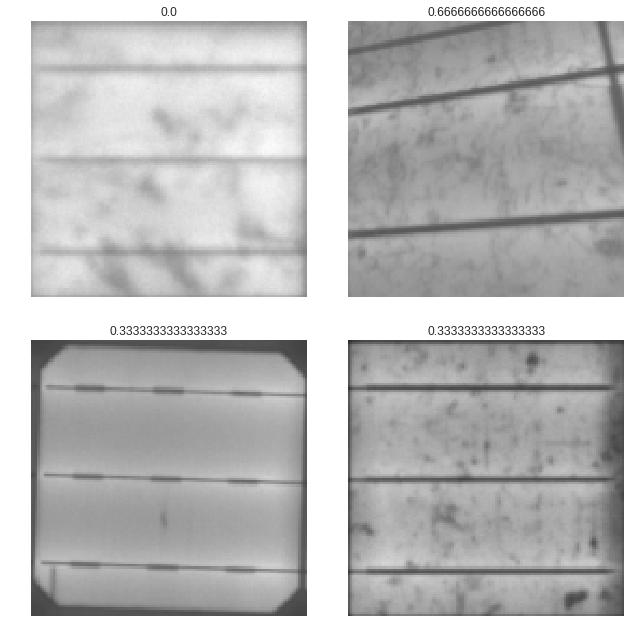

In [120]:
data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

In [0]:
arch = models.resnet18

In [0]:
learn = create_cnn(data, arch, metrics=[accuracy], callback_fns=[ShowGraph])

In [137]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 150, 150]   9408       False     
______________________________________________________________________
BatchNorm2d          [64, 64, 150, 150]   128        True      
______________________________________________________________________
ReLU                 [64, 64, 150, 150]   0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 75, 75]     0          False     
______________________________________________________________________
Conv2d               [64, 64, 75, 75]     36864      False     
______________________________________________________________________
BatchNorm2d          [64, 64, 75, 75]     128        True      
______________________________________________________________________
ReLU                 [64, 64, 75, 75]     0          False     
______________________________________________________________

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


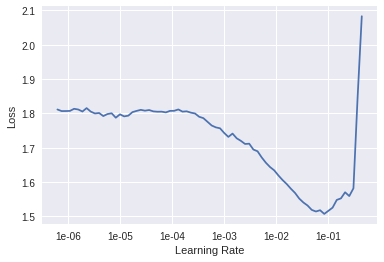

In [138]:
learn.lr_find(); learn.recorder.plot()

In [0]:
lr = 5e-3

epoch,train_loss,valid_loss,accuracy
1,1.533063,1.156332,0.549618
2,1.229394,0.820612,0.711832
3,1.054223,0.809082,0.690840
4,0.952677,0.758113,0.698473
5,0.887276,0.705346,0.734733
6,0.824099,0.690955,0.738550
7,0.786896,0.705293,0.750000
8,0.761880,0.659280,0.759542
9,0.732114,0.665190,0.763359
10,0.703551,0.662640,0.765267


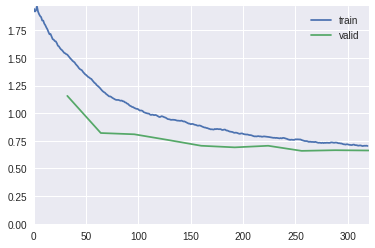

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f31abec2358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f31abec2358>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 717, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", 

In [140]:
learn.fit_one_cycle(10, lr)

In [0]:
learn.unfreeze()

In [144]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 64, 150, 150]   9408       True      
______________________________________________________________________
BatchNorm2d          [64, 64, 150, 150]   128        True      
______________________________________________________________________
ReLU                 [64, 64, 150, 150]   0          False     
______________________________________________________________________
MaxPool2d            [64, 64, 75, 75]     0          False     
______________________________________________________________________
Conv2d               [64, 64, 75, 75]     36864      True      
______________________________________________________________________
BatchNorm2d          [64, 64, 75, 75]     128        True      
______________________________________________________________________
ReLU                 [64, 64, 75, 75]     0          False     
______________________________________________________________

epoch,train_loss,valid_loss,accuracy
1,0.721242,1.043485,0.589695
2,0.742334,1.444745,0.580153
3,0.726921,0.719507,0.711832
4,0.689550,0.591530,0.797710
5,0.635478,0.531079,0.811069
6,0.595531,0.514337,0.822519


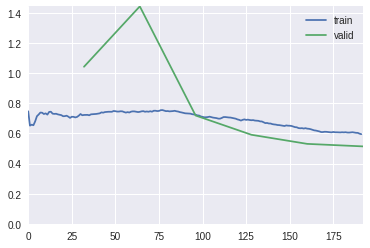

In [145]:
learn.fit_one_cycle(6, slice(lr/12, lr/5))

In [0]:
learn.data = get_data(sz=300)

In [0]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


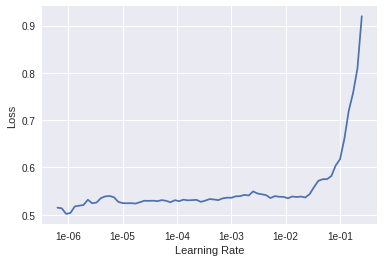

In [148]:
learn.lr_find(); learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy
1,0.530308,0.520354,0.818702
2,0.524709,0.514770,0.814885
3,0.524939,0.517988,0.816794
4,0.531728,0.518727,0.812977
5,0.529464,0.520075,0.816794
6,0.532791,0.519034,0.818702
7,0.517120,0.520934,0.818702
8,0.522377,0.519334,0.816794
9,0.528663,0.520238,0.816794
10,0.532390,0.526258,0.818702


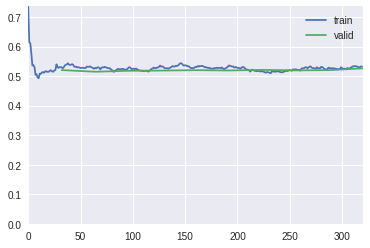

In [149]:
learn.fit_one_cycle(10, slice(1e-4))

In [0]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy
1,0.528195,0.518635,0.818702
2,0.518990,0.520081,0.814885
3,0.511073,0.509469,0.824427
4,0.515402,0.509822,0.816794
5,0.499259,0.538575,0.811069
6,0.488178,0.508593,0.820611
7,0.474335,0.515354,0.814885
8,0.471575,0.513857,0.814885
9,0.463361,0.513670,0.818702
10,0.455065,0.517039,0.818702


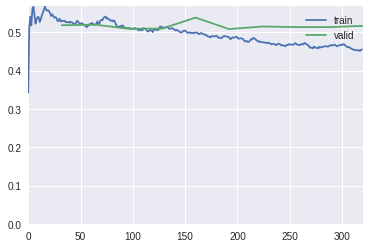

In [151]:
learn.fit_one_cycle(10, slice(1e-5, 1e-4))